# Test my crowding code as if in the driver

In [2]:
sys.path.insert(0, '/Users/ageller/WORK/LSST/onGitHub/EBLSST/code')
from LSSTEBClusterWorker import LSSTEBClusterWorker
from OpSim import OpSim
from getClusterBinaries import getClusterBinaries

%load_ext autoreload
%autoreload 2

/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/ageller/python_scripts/PySynphotData/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))
/Users/ageller/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2286: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [22]:
import pandas as pd
import numpy as np

import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from jupyterthemes import jtplot
jtplot.style(theme='chesterish', grid=False)

In [3]:
GCDF = pd.read_csv("/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/clusters/GCdataForEBLSST.csv").fillna(0.)
field = GCDF.loc[GCDF['ID'] == 'NGC 6254'] #M10 GC
field

,ID,RA[hr],Dec[deg],dist[pc],rhm[pc],mass[Msun],age[Myr],[Fe/H],sigma_v0_z[km/s],OpSimID,OpSimRA[deg],OpSimDec[deg]
59,NGC 6254,16 57 09.05,-04 06 01.1,4400.0,2.495821,177431.202408,10345.238095,-1.56,6.6,2413.0,253.606593,-5.090318


In [4]:
OpS = OpSim()
OpS.dbFile = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/db/baseline2018a.db'
OpS.getCursors()

have summary cursor.
have field cursor.


In [5]:
OpS.fieldID = field['OpSimID'].values
OpS.RA = field['OpSimRA[deg]'].values
OpS.Dec = field['OpSimDec[deg]'].values
OpS.obsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.NobsDates = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.m_5 = np.full_like(OpS.fieldID, dict(), dtype=dict)
OpS.totalNobs = np.full_like(OpS.fieldID, 0)

In [6]:
OpSimi = 0
worker = LSSTEBClusterWorker()
worker.filterFilesRoot = '/Users/ageller/WORK/LSST/onGitHub/EBLSST/input/filters/'
worker.clusterName = field['ID'].values
worker.clusterMass = field['mass[Msun]'].values
worker.clusterDistance = field['dist[pc]'].values/1000.
worker.clusterMetallicity = field['[Fe/H]'].values
worker.clusterAge = field['age[Myr]'].values
worker.clusterRhm = field['rhm[pc]'].values
worker.clusterVdisp = field['sigma_v0_z[km/s]'].values
    
worker.OpSim = OpS

worker.seed = 1111

worker.initialize(OpSimi)

total number of OpSim observation dates (all filters) = 951.0


True

In [7]:
worker.galDir = 'TRILEGALmodels'
#using these flags so that I don't have to download each time
worker.getGalaxy(OpSimi, deleteModel = False, downloadModel = False) 

downloaded TRILEGAL model for ID=2413.0, RA=253.606593, DEC=-5.090318, Nstars=409023.0, Nstars/resEl=0.0006440901360544218


In [8]:
worker.n_bin = 100
clusterDat = worker.sampleCluster(OpSimi)
print(worker.clusterSampler.bcmEvolved)

sampling cluster NGC 6254
initial binary input: 1111 10345.238095238095 -1.56 100 6.6 4.0
Number of binaries 73
           tphys  kstar_1   mass0_1    mass_1       lumin_1     rad_1  \
0   10345.238095      0.0  0.560664  0.560664  1.271253e-01  0.502036   
1   10345.238095      0.0  0.554351  0.554351  1.203283e-01  0.495169   
2   10345.238095      0.0  0.291015  0.291015  1.971843e-02  0.276870   
3   10345.238095     11.0  0.782429  0.782429  2.580613e-06  0.010514   
4   10345.238095      0.0  0.255751  0.255751  1.583187e-02  0.252346   
5   10345.238095      0.0  0.299821  0.299821  2.075053e-02  0.282913   
6   10345.238095     11.0  0.543642  0.543642  6.659132e-06  0.013568   
7   10345.238095      0.0  0.652936  0.652936  2.955547e-01  0.612806   
8   10345.238095      0.0  0.202401  0.202401  1.031778e-02  0.212461   
9   10345.238095      0.0  0.295136  0.295136  2.019738e-02  0.279700   
10  10345.238095     11.0  0.630214  0.630214  5.260380e-06  0.012377   
11  10345.23

In [9]:
i = 50
line = clusterDat[i]
#change the inclination
line[12] = np.pi/2.
#change the period
line[2] = np.log10(3.47)
print(line)

EB = worker.getEB(line, OpSimi=OpSimi)

print(worker.EB.crowding.clusterRPlummer)
print(worker.EB.observable)
print(worker.EB.radius_failed, worker.EB.period_failed, worker.EB.incl_failed, worker.EB.appmag_failed)
print(worker.EB.appMagMean)

print(worker.EB.crowding.backgroundFlux)
print(worker.EB.crowding.backgroundMag)
print(worker.EB.light_3)

[0.8161502197119102 0.8058509779650708 0.5403294747908738
 0.6731676729250042 0.9958202599544346 0.9476405520769932
 1.8583350977115927 1.568771081438117 None None None 4.4
 1.5707963267948966 4.359417462764987 3.9712048708210927 None -1.56
 6783.598560229484 6665.576023464465 0.0 0.0]
getting crowding ... 
initial single input: 1111 10345.238095238095 -1.56 80
1.9128495433910215
True
0 0 0 0
{'u_': <Quantity 18.9998263>, 'g_': <Quantity 17.88344933>, 'r_': <Quantity 17.38595906>, 'i_': <Quantity 17.17075253>, 'z_': <Quantity 17.08534271>, 'y_': <Quantity 17.05675603>}
{'u_': 6.999344592223959e-07, 'g_': 6.999344592223959e-07, 'r_': 6.999344592223959e-07, 'i_': 6.999344592223959e-07, 'z_': 6.999344592223959e-07, 'y_': 6.999344592223959e-07}
{'u_': 16.728311220059737, 'g_': 16.410437184170327, 'r_': 16.094996281130943, 'i_': 15.90347732965319, 'z_': 15.787196094324756, 'y_': 15.720423391957146}
{'u_': <Quantity 8.10225735>, 'g_': <Quantity 3.88333503>, 'r_': <Quantity 3.28386362>, 'i_':

In [10]:
print(worker.EB.crowding.xBinary, worker.EB.crowding.yBinary)
print(worker.EB.crowding.clusterNstars)
print(worker.EB.crowding.nCrowdCluster)
print(worker.EB.crowding.clusterSingles)
print(worker.EB.crowding.nCrowdGalaxy)
print(worker.EB.crowding.galaxySingles)


[-0.28728143] [0.43098139]
354862.4048151847
80
           tphys  kstar_1    mass0_1    mass_1       lumin_1     rad_1  \
78  10345.238095     12.0   1.316487  1.316487  3.459478e-06  0.002883   
43  10345.238095     13.0  11.957755  1.208609  2.130461e-10  0.000014   
36  10345.238095     12.0   1.205869  1.205869  3.212250e-06  0.004880   
45  10345.238095     12.0   1.202680  1.202680  3.206908e-06  0.004928   
10  10345.238095     11.0   1.033300  1.033300  2.878220e-06  0.007681   
24  10345.238095     11.0   1.003195  1.003195  3.100847e-06  0.008022   
70  10345.238095      1.0   0.853431  0.853431  4.948818e+00  1.512187   
37  10345.238095     11.0   0.846496  0.846496  3.790086e-06  0.009780   
20  10345.238095     11.0   0.841174  0.841174  3.857677e-06  0.009841   
61  10345.238095     11.0   0.811102  0.811102  4.264758e-06  0.010184   
52  10345.238095     11.0   0.803308  0.803308  4.419775e-06  0.010273   
7   10345.238095     11.0   0.797629  0.797629  4.570014e-06  0.

In [11]:
#now plot the crowding
if (worker.EB.crowding.clusterSingles is not None):
    f,ax = plt.subplots(1,6, figsize=(15, 5))
    for i,f in enumerate(worker.filters):
        ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f])#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.clusterSingles['xAng'], 
                      worker.EB.crowding.clusterSingles['yAng'], s=3, color='white')

In [12]:
if (worker.EB.crowding.galaxySingles is not None):
    f,ax = plt.subplots(1,6, figsize=(15, 5))
    for i,f in enumerate(worker.filters):
        ax[i].pcolormesh(worker.EB.crowding.xgrid, worker.EB.crowding.ygrid, 
                         worker.EB.crowding.fluxgrid[f])#, norm=colors.LogNorm())
        ax[i].set_aspect(1)
        ax[i].set_title(f)
        ax[i].scatter(worker.EB.crowding.galaxySingles['xAng'], 
                      worker.EB.crowding.galaxySingles['yAng'], s=3, color='white')

In [13]:
print(worker.EB.light_3)

{'u_': <Quantity 8.10225735>, 'g_': <Quantity 3.88333503>, 'r_': <Quantity 3.28386362>, 'i_': <Quantity 3.21299524>, 'z_': <Quantity 3.30566353>, 'y_': <Quantity 3.42399448>}


In [36]:
#also check the light curve
worker.run_ellc()
appMagObs = worker.EB.appMagObs.copy()
appMag = worker.EB.appMag.copy()

#and check with no light_3 as a comparison
light_3 = {}
for f in worker.filters:
    light_3[f] = 0.
worker.run_ellc(light_3 = light_3)
appMagObs_noLight3 = worker.EB.appMagObs.copy()
appMag_noLight3 = worker.EB.appMag.copy()

using light_3 u_ 8.102257347021402
using light_3 g_ 3.8833350284691828
using light_3 r_ 3.2838636206059295
using light_3 i_ 3.2129952381743028
using light_3 z_ 3.305663534920594
using light_3 y_ 3.4239944821088764
using light_3 u_ 0.0
using light_3 g_ 0.0
using light_3 r_ 0.0
using light_3 i_ 0.0
using light_3 z_ 0.0
using light_3 y_ 0.0


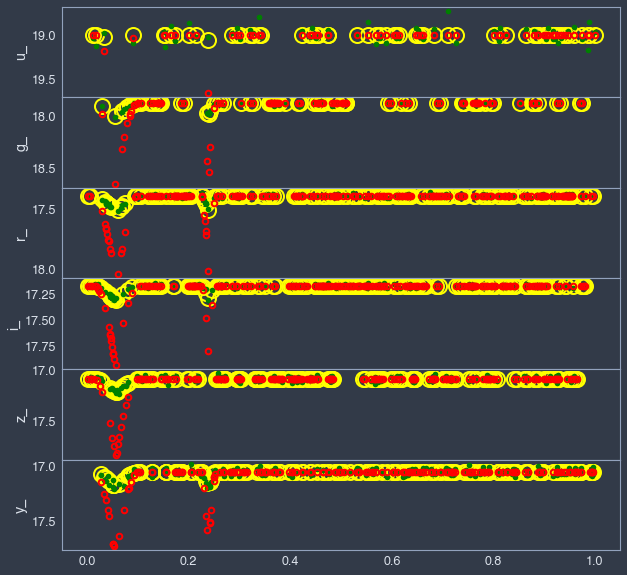

In [66]:
fig,ax = plt.subplots(6,1, figsize=(10,10), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (worker.EB.obsDates[f] % worker.EB.period)/worker.EB.period
    ax[i].plot(phase, appMag[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    ax[i].plot(phase, appMagObs[f],'o', color='green')

    ax[i].plot(phase, appMag_noLight3[f],'o', color='red', mew=2, mfc='none')
    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(f)

plt.subplots_adjust(hspace=0)


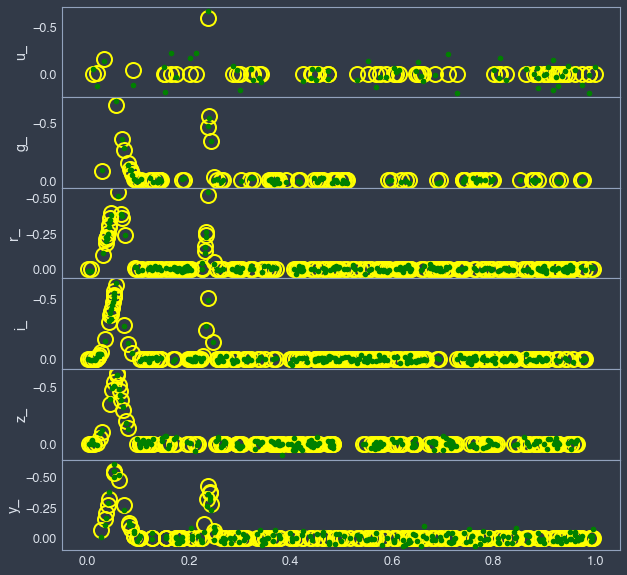

In [67]:
fig,ax = plt.subplots(6,1, figsize=(10,10), sharex = True)
for i,f in enumerate(worker.filters):
    #with crowding
    phase = (worker.EB.obsDates[f] % worker.EB.period)/worker.EB.period
    ax[i].plot(phase, appMag[f] - appMag_noLight3[f],'o',  mec='yellow', mfc='none', mew=2, markersize=15)
    ax[i].plot(phase, appMagObs[f] - appMagObs_noLight3[f],'o', color='green')

    #ax[i].plot(phase, appMagObs_noLight3[f],'.', color='orange')

    ax[i].set_ylim(ax[i].get_ylim()[::-1])
    ax[i].set_ylabel(f)

plt.subplots_adjust(hspace=0)